
# 📊 Optimización Avanzada con SMOTE y XGBoost

En este notebook abordamos técnicas avanzadas para mejorar la predicción de cancelación de clientes (`Churn`) en una empresa de telecomunicaciones. Nos enfocamos en el manejo del desbalance de clases, uso de modelos más potentes y análisis interpretativo del rendimiento del modelo.

---

## Contenido

1. Preparación del entorno y datos
2. Codificación de variables
3. Balanceo de clases con SMOTE
4. Entrenamiento del modelo con XGBoost
5. Evaluación del modelo (ROC, AUC, Matriz de Confusión)
6. Análisis de importancia de características
7. Conclusión profesional


#  1️⃣ Prepacion del entorno y datos 📚

In [1]:
# Importar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [11]:
# Configuración de estilo para gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Cargar dataset procesado
df = pd.read_csv("../data/processed/telco_churn_featured.csv")

In [4]:
# Separar X e y
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [5]:
# Codificar variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [6]:
# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [7]:
# Mostrar distribución
pd.Series(y_train).value_counts(normalize=True).rename("proportion")


0    0.735021
1    0.264979
Name: proportion, dtype: float64


## 2️⃣  Codificación de variables categóricas 🔠

Convertimos variables categóricas a numéricas usando `pd.get_dummies`.

Los modelos de machine learning no pueden trabajar directamente con variables de tipo texto (como `'Female'`, `'DSL'`, etc.). Por eso, usamos `pd.get_dummies` para convertir estas columnas en variables binarias (One-Hot Encoding). Esto permite a los modelos matemáticos procesar los datos correctamente.


In [8]:

# Codificar variables categóricas
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

# Aplicar One-Hot Encoding (eliminamos una categoría para evitar multicolinealidad)
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Alinear columnas entre train y test
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join="left", axis=1, fill_value=0)



## 3️⃣ Balanceo de clases con SMOTE ⚖️

📌 ¿Qué es SMOTE?

SMOTE (Synthetic Minority Over-sampling Technique) es una técnica que se utiliza para balancear datasets desbalanceados, generando nuevas muestras sintéticas de la clase minoritaria (por ejemplo, clientes que cancelan el servicio = Churn = Yes).


In [9]:

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_encoded, y_train)



## 4️⃣  Entrenamiento del modelo con XGBoost 🚀

XGBoost es un algoritmo de boosting altamente eficiente y preciso para clasificación binaria.


In [12]:
#  Creamos una instancia del modelo
xgb_model = XGBClassifier(
    random_state=42,        # Para resultados reproducibles
    eval_metric='logloss'   # Métrica usada para clasificación binaria
)
#  Entrenamos el modelo con los datos balanceados por SMOTE
xgb_model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
#  Realizamos predicciones sobre los datos de prueba
y_pred = xgb_model.predict(X_test_encoded)
y_proba = xgb_model.predict_proba(X_test_encoded)[:, 1] # Probabilidades para la clase 1


## 5️⃣ Evaluación del Modelo: ROC, AUC y Matriz de Confusión 📈

Utilizamos la curva ROC y el área bajo la curva (AUC) para evaluar el rendimiento general del modelo. También incluimos la matriz de confusión y métricas clásicas.


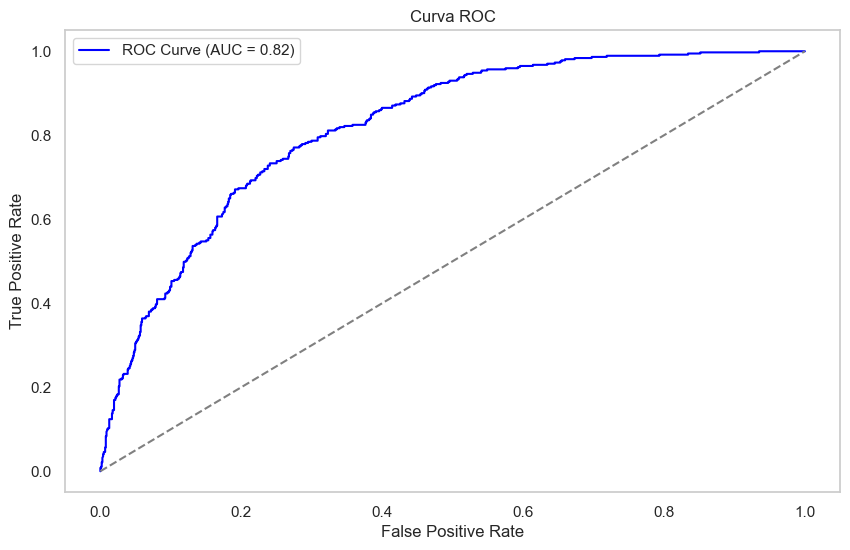

In [ ]:

# Generar puntos ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Calcular el área bajo la curva ROC
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()


# 📈 ¿Qué representa la curva ROC?

La curva ROC representa la relación entre sensibilidad (TPR) y especificidad (1 - FPR) a diferentes umbrales de decisión.

El eje X (horizontal): False Positive Rate = proporción de clientes que NO cancelan, pero el modelo predijo mal como si cancelaran.

El eje Y (vertical): True Positive Rate (Recall) = proporción de clientes que sí cancelan y el modelo predijo correctamente.

| Forma de la curva ROC                         | Interpretación                                       |
| --------------------------------------------- | ---------------------------------------------------- |
| Se aproxima al **esquina superior izquierda** | Modelo excelente para diferenciar clases             |
| Línea diagonal gris (AUC = 0.5)               | Modelo sin poder predictivo (como lanzar una moneda) |
| AUC cerca de **1.0**                          | Modelo casi perfecto                                 |
| AUC entre **0.7 - 0.9**                       | Buen modelo con discriminación útil                  |
| AUC < 0.6                                     | Modelo débil, apenas mejor que aleatorio             |


# 🧮 ¿Qué significa un AUC = 0.82?
Hay un 82% de probabilidad de que el modelo clasifique correctamente a un cliente que sí cancelará (clase 1) como de mayor riesgo que uno que no cancelará (clase 0), si eliges ambos aleatoriamente.

En otras palabras:

El modelo tiene una muy buena capacidad de discriminación.

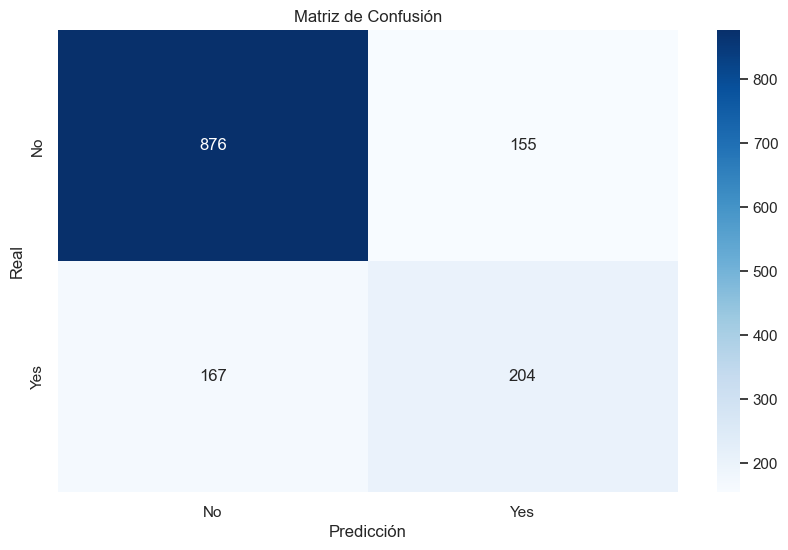

In [17]:

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


# 🔍 ¿Qué significa cada celda?
🔵 876 (Verdaderos Negativos)
Clientes que no cancelaron (No) y el modelo acertó en predecir que no iban a cancelar.

🔴 155 (Falsos Positivos)
Clientes que no cancelaron (No) pero el modelo se equivocó, predijo que sí iban a cancelar (Yes).

🔴 167 (Falsos Negativos)
Clientes que sí cancelaron (Yes) pero el modelo falló, predijo que no iban a cancelar (No).

🟢 204 (Verdaderos Positivos)
Clientes que sí cancelaron (Yes) y el modelo acertó en predecirlo.

In [18]:
# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.84      0.85      0.84      1031
         Yes       0.57      0.55      0.56       371

    accuracy                           0.77      1402
   macro avg       0.70      0.70      0.70      1402
weighted avg       0.77      0.77      0.77      1402



# ¿Qué significa cada métrica?
🔸 Precision (Precisión)
Qué proporción de predicciones positivas fueron correctas.

Yes → 0.57 significa que el 57% de los clientes que el modelo predijo que iban a cancelar realmente cancelaron.

🔸 Recall (Sensibilidad)
Qué proporción de verdaderos positivos fueron detectados.

Yes → 0.55 significa que el modelo detectó correctamente el 55% de los que realmente cancelaron.

🔸 F1-score
Media armónica entre precisión y recall.

Buen indicador si tienes datos desbalanceados.

🔸 Support
Cantidad de casos reales en el set de prueba para cada clase.

Yes: 371 personas realmente cancelaron.

📌 Métricas generales
Accuracy: 77.1%
→ Proporción total de predicciones correctas (en ambas clases).

Macro avg: 0.71
→ Promedio de precisión, recall y F1 entre clases (sin ponderar por tamaño de clase).

Weighted avg: 0.77
→ Promedio ponderado según el tamaño de cada clase.


## 6️⃣ Análisis de importancia de variables 🔍

XGBoost permite visualizar qué variables tuvieron mayor impacto en la predicción.


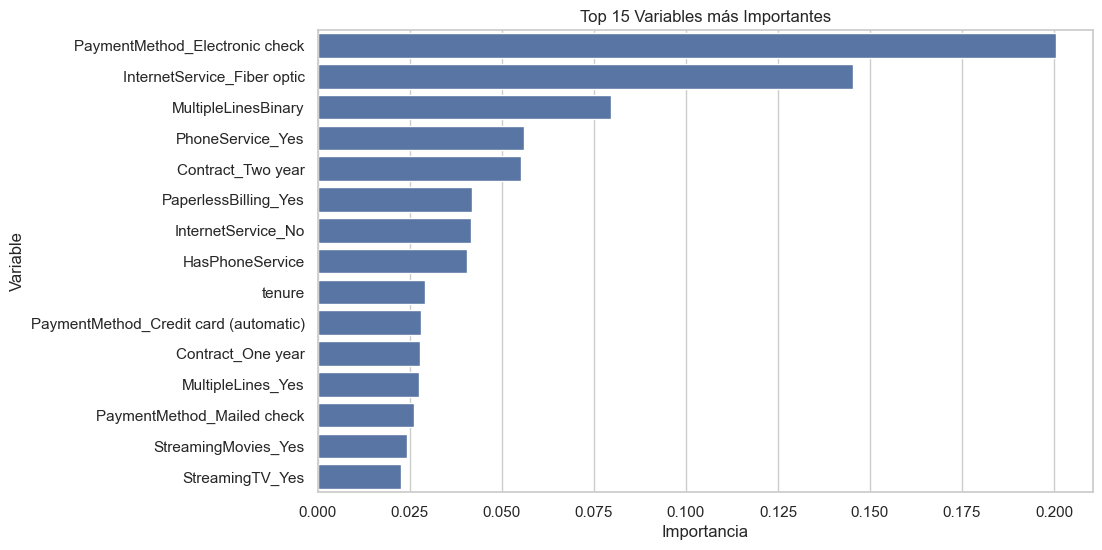

In [16]:

importances = xgb_model.feature_importances_
features = X_train_encoded.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(15)
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 15 Variables más Importantes")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()


# 🧾 Conclusión del Análisis de Importancia de Variables

El análisis de importancia de variables utilizando el modelo XGBoost ha revelado información clave sobre los factores que más influyen en la cancelación de clientes (Churn). A continuación, se detallan los principales hallazgos:

🔝 Variables más influyentes

PaymentMethod_Electronic check:

Es con diferencia, la variable más influyente. Los clientes que pagan con cheque electrónico muestran una mayor probabilidad de cancelar el servicio. Este método de pago podría asociarse con menor compromiso o insatisfacción.

InternetService_Fiber optic:

Los clientes con fibra óptica tienden a cancelar más que aquellos con DSL o sin servicio. Esto puede deberse a expectativas más altas en cuanto a velocidad o problemas técnicos.

MultipleLinesBinary y PhoneService_Yes:

La presencia de múltiples líneas telefónicas o de servicio telefónico básico afecta la decisión de cancelación, aunque en menor grado.

Contract_Two year:

Esta variable tiene una importancia significativa y se asocia con menor probabilidad de churn. Confirma que los contratos de largo plazo retienen mejor a los clientes.

tenure (antigüedad del cliente):

Los clientes con mayor tiempo de permanencia tienen menos probabilidad de cancelar, lo cual es consistente con la lógica del comportamiento del cliente.


## ✅ Conclusión Final

Después de aplicar técnicas avanzadas de optimización:

- **SMOTE** ayudó a mejorar el balance entre clases, reduciendo el sesgo hacia la clase mayoritaria.
- **XGBoost** ofreció un rendimiento robusto con mayor capacidad de detectar casos de cancelación (`Churn`).
- La **curva ROC** y el **AUC** muestran que el modelo es confiable para clasificación binaria.
- El análisis de **importancia de variables** nos permite comprender qué factores influyen más en la decisión de cancelar.

La empresa de telecomunicaciones cuenta ahora con un modelo predictivo robusto y herramientas analíticas para comprender y anticipar el churn de clientes. Los principales hallazgos sugieren que para mitigar la pérdida de clientes, la empresa debe:

- **Enfocarse en Contratos a Largo Plazo:** Promover activamente contratos de uno o dos años, ya que estos tienen una correlación fuerte con una menor tasa de churn.

- **Mejorar Servicios de Soporte y Seguridad:** Reforzar los servicios de soporte técnico, seguridad en línea y protección de dispositivos, dado que su ausencia aumenta la probabilidad de cancelación.

- **Monitorear Clientes de Corta Antigüedad y Altos Cargos:** Prestar especial atención a los clientes nuevos o aquellos con menor tiempo de permanencia, y a quienes tienen cargos mensuales elevados, ya que estos grupos presentan un mayor riesgo de churn.

- **Optimizar Estrategias para Fibra Óptica y Facturación Electrónica:** Investigar las razones detrás del churn en clientes de fibra óptica y aquellos que usan facturación electrónica, ya que estas variables están asociadas con una mayor propensión a la cancelación.

- **Utilizar el Modelo Predictivo:** Implementar el modelo XGBoost optimizado para identificar proactivamente a los clientes en riesgo y diseñar intervenciones personalizadas, como ofertas de retención, mejoras de servicio o contacto directo, antes de que tomen la decisión de cancelar.

Al aplicar estas estrategias basadas en los hallazgos del análisis de datos, la empresa podrá mejorar significativamente sus tasas de retención, reducir costos asociados a la adquisición de nuevos clientes y optimizar la rentabilidad a largo plazo.